In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2 
import glob

import tqdm

from nd2reader import ND2Reader
import h5py
import pickle
import json

import datetime

import warnings
warnings.filterwarnings('ignore')

import ffmpeg

from skimage.filters import rank, threshold_otsu, threshold_local#
from skimage import morphology

import scipy 
import skimage

import pandas as pd
import seaborn as sns
import csv

from tools.func import *

c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
#Draw rectangle to images
def mousePoints(event,x,y,flags,param):
    #Crop image
    global refPt
    global img
    global final_boundaries
    global stopper
    # Left button click
    if event == cv2.EVENT_LBUTTONDOWN:
        refPt = [(x, y)]
    elif event == cv2.EVENT_LBUTTONUP:
        refPt.append((x, y))
        final_boundaries.append((refPt[0],refPt[1]))
        stopper = True
        cv2.imshow("win", img)
        print("two clicks!")
    elif event == cv2.EVENT_MOUSEMOVE and flags == cv2.EVENT_FLAG_LBUTTON:
        clone = img.copy()
        cv2.rectangle(clone, refPt[0], (x, y), (0, 255, 0), 4)
        cv2.imshow("win", clone)



def parse_raw_dict(day, video_path, own_meta):

    fh = video_path

    parts = os.path.split(video_path)[-1].split("_")
    day = str(parts[0])

    label_map = None

    if isinstance(fh, str):
        if not fh.endswith(".nd2"):
            raise InvalidFileType(
                ("The file %s you want to read with nd2reader" % fh)
                + " does not have extension .nd2."
            )
        
        filename = fh

        fh = open(fh, "rb")

    _fh = fh
    _fh.seek(-8, 2)
    chunk_map_start_location = struct.unpack("Q", _fh.read(8))[0]
    _fh.seek(chunk_map_start_location)
    raw_text = _fh.read(-1)
    label_map = LabelMap(raw_text)
    datasTT = RawMetadata(_fh, label_map)


    seeding_density = []
    well_name = []
    well_info = datasTT.image_metadata[b'SLxExperiment'][b'ppNextLevelEx'][b''][b'uLoopPars'][b'Points'][b'']
    for i in range(len(well_info)):
        
        label = (well_info[i][b'dPosName']).decode("utf8")
        lable_parts = label.split("_")
        if len(lable_parts) == 1:
            seeding_density.append(500)
        else:
            try:
                seeding_density.append(int(lable_parts[1]))
            except:
                seeding_density.append(500)
                print(lable_parts[1])

        well_name.append(lable_parts[0])

    own_meta[day]["cell"] = well_name
    own_meta[day]["seeding_density"] = seeding_density
    own_meta[day]["dt"] = datasTT.image_metadata[b'SLxExperiment'][b'uLoopPars'][b'dPeriod']*1e-3

    return own_meta
        

In [3]:
root_path = "D:/instru_projects/TimeLapses/u-wells/*"
target_paths = glob.glob(os.path.join(root_path, "*.nd2"))

In [5]:
with open('C:/Users/lehtona6/codes/InstruProject/NikonPipes/dataStore/metalib.json', 'r') as f:
  own_meta = json.load(f)

print(own_meta.keys())

dict_keys(['name', '230417', '240304', '240502', '240426', '240307', '240226', '240301', '240311', '240223', '240228', '240302', '240305', '240306', '240312', '230418', '240519', '240520', '240521', '240522'])


'MCFA10A'

In [7]:
with open('C:/Users/lehtona6/codes/InstruProject/NikonPipes/dataStore/metalib.json', 'r') as f:
  own_meta = json.load(f)


coord_dict = {}

skip_existing = False
map_coord = True

for video_path in target_paths:

    parts = os.path.split(video_path)[-1].split("_")
    day = str(parts[0])
    matrix = parts[2]
    n_ines = parts[3][0]
    start_time = int(parts[4][:-1])
    comments = parts[5][:-3]

    if day not in own_meta.keys():
        own_meta[day] = {}
    elif skip_existing:
        continue

    own_meta[day]["matrix"]  = matrix
    own_meta[day]["n_cells"]  = n_ines
    own_meta[day]["dim"] = "3D"
    own_meta[day]["incubation_time"] = start_time
    own_meta[day]["other"] = "other"

    own_meta = parse_raw_dict(day, video_path, own_meta)
    
    if map_coord:

        with ND2Reader(video_path) as images:

            coords = []
            final_boundaries = []
            metas = load_metadata(images)
            z_levels = metas["n_levels"]
            vis_level = int(z_levels/2)
            stopper = False

            for i in range(metas["n_fields"]):

                cv2.namedWindow('win',cv2.WINDOW_NORMAL)
                cv2.setMouseCallback("win", mousePoints)

                img = images.get_frame_2D(c=0, t=0, z=vis_level, x=0, y=0, v=i)
                cv2.imshow("win",img)

                k = cv2.waitKey(0)

                if k == ord("q"):  # Press q to quit
                    break

                if stopper == True:

                    stopper = False
                    coords.append(final_boundaries)
                    final_boundaries = []
                    cv2.destroyAllWindows()


            cv2.destroyAllWindows()

            if k == ord("q"):  # Press q to quit
                break

        final_coords = []

        for i in range(len(coords)):
            final_coords.append([[coords[i][0][0][0], coords[i][0][0][1]], [coords[i][0][1][0], coords[i][0][1][1]]])

        
        own_meta[day]["coords"] = final_coords
        
        if k == ord("q"):  # Press q to quit
            break


    with open('./dataStore/metalib.json', 'w', encoding='utf-8') as f:
        json.dump(own_meta, f, ensure_ascii=False, indent=4)


two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!


In [8]:
with open('C:/Users/lehtona6/codes/InstruProject/NikonPipes/dataStore/metalib.json', 'r') as f:
    own_meta = json.load(f)

for video_path in target_paths:

    parts = os.path.split(video_path)[-1].split("_")
    day = str(parts[0])
    own_meta = parse_raw_dict(day, video_path, own_meta)

    with ND2Reader(video_path) as images:
        metas = load_metadata(images)

    for k in metas.keys():
        own_meta[day][k] = metas[k]

with open('./dataStore/metalib.json', 'w', encoding='utf-8') as f:
    json.dump(own_meta, f, ensure_ascii=False, indent=4)


In [12]:
with open('C:/Users/lehtona6/codes/InstruProject/NikonPipes/dataStore/metalib.json', 'r') as f:
  own_meta = json.load(f)

scaler = 350


for video_path in tqdm.tqdm(target_paths, total=len(target_paths)):

    video_name = os.path.split(video_path)[-1][:-4]
    root_path = os.path.split(video_path)[0]
    results = os.path.join(root_path, "results_{}".format(video_name))
    os.makedirs(results, exist_ok=True)

    parts = os.path.split(video_path)[-1].split("_")
    day = str(parts[0])

    coords = own_meta[day]["coords"]

    loc_id = 0
    t_id = 0
    channel = "BF"
    track_list = []
    total_dict = {}

    out_name = os.path.join(results,'{}_{}_{}.mp4'.format(os.path.split(video_path)[1][:-4], (loc_id), datetime.date.today() ) )
    #out_process = cv2.VideoWriter(out_name, cv2.VideoWriter_fourcc(*"mp4v"), 20, (2304,2304))
    out_process = ( 
    ffmpeg 
    .input('pipe:', format='rawvideo', pix_fmt='rgb24', s='{}x{}'
    .format(2304, 2304)) 
    .output(out_name, pix_fmt='yuv420p') .overwrite_output() 
    .run_async(pipe_stdin=True) 
    )

    with ND2Reader(video_path) as images:
        #c -channel, v - locations, t - time
        
        metas = load_metadata(images)
        images.iter_axes = "vt"
        images.bundle_axes = "zyx"

        area_th = int(40/metas["m"])**2*np.pi
        vis_level = int(metas["n_levels"]/2)
        frames_tot = int((metas["n_channels"]*metas["n_fields"]*metas["n_frames"]))
        x_final = coords[loc_id][0] #(0,2304)
        y_final = coords[loc_id][1] #(2304,0) 


        for idx, img in tqdm.tqdm(enumerate(images),total=frames_tot):

            c_id = idx%metas["n_channels"]
            id_name = metas["channels"][c_id]


            if (id_name != channel) : #| (loc_id != 1)
                #t_id += 1
                #if t_id == metas["n_frames"]:
                #    t_id = 0
                #    loc_id += 1
                continue

            projected_frame =  np.min(img, axis = 0)
            th = np.percentile(projected_frame.flatten(),5)
            projected_frame[projected_frame>th] = 0
            
            x, y, r, area, x_start, y_start, mask = process_frame(projected_frame, x_final, y_final)

            if area < area_th:
                print("No object found")
            else:
                x_final = x_start
                y_final = y_start

            focus_level = 1e10
            focus_idx = 0

            for i in range(img.shape[0]):

                current_frame = img[i].copy()
                cropped = current_frame[x_final[1]:y_final[1], x_final[0]:y_final[0]]
                
                if (cropped.shape[0] == 0) or (cropped.shape[1] == 0):
                    lap = np.inf
                else:
                    lap = cv2.Laplacian(cropped, cv2.CV_64F).var()

                if focus_level < lap:

                    focus_level = lap
                    focus_idx = i

            int_frame = (img[focus_idx]*2**8/(2**16)).astype("uint8")
            int_frame = np.stack((int_frame,int_frame,int_frame), axis = -1)
            img_normalized = cv2.normalize(int_frame, None, 0, 255, cv2.NORM_MINMAX)
            img_normalized = cv2.cvtColor(img_normalized, cv2.COLOR_BGR2RGB)
            cv2.rectangle(img_normalized, x_start, y_start, (2**16,0,0), 5)
            int_mask = (mask.astype(bool)*255).astype("uint8")
            int_mask = np.stack((int_mask,int_mask,int_mask), axis = -1)
            out_vis = cv2.addWeighted(img_normalized,1.0,int_mask,0.75,0)

            #plt.imshow(out_vis)
            #plt.show()

            out_process.stdin.write(out_vis)
            #out_process.write(out_vis)
                
            track_list.append([x*metas["m"], y*metas["m"], r*metas["m"], area*metas["m"]**2, (focus_idx-1)*metas["z_step"], mask])
            t_id += 1

            if t_id == metas["n_frames"]:

                total_dict = pile_data(track_list, total_dict, loc_id, channel)

                out_process.stdin.close()
                out_process.wait()
                #out_process.release()

                with open(os.path.join(results,'{}_detections.pkl'.format(os.path.split(video_path)[1][:-4])), 'wb') as f:
                    pickle.dump(total_dict, f)

                t_id = 0
                loc_id += 1
                track_list = []
                if loc_id == metas["n_fields"]:
                    break
                
                x_final = coords[loc_id][0] #(0,2304)
                y_final = coords[loc_id][1] #(2304,0) 

                #if loc_id == 2:
                #    break
                
                out_name = os.path.join(results,'{}_{}_{}.mp4'.format(os.path.split(video_path)[1][:-4], (loc_id), datetime.date.today() ) )
                #out_process = cv2.VideoWriter(out_name, cv2.VideoWriter_fourcc(*"mp4v"), 20, (2304,2304))
                out_process = ( 
                ffmpeg 
                .input('pipe:', format='rawvideo', pix_fmt='rgb24', s='{}x{}'
                .format(2304, 2304)) 
                .output(out_name, pix_fmt='yuv420p') .overwrite_output() 
                .run_async(pipe_stdin=True) 
                )

    out_process.stdin.close()
    out_process.wait()
    #out_process.release()


  0%|          | 0/1 [00:00<?, ?it/s]

No object found


No object found


No object found


No object found


No object found


No object found


No object found


No object found


No object found


No object found


No object found


No object found


No object found


No object found


100%|██████████| 1/1 [32:02<00:00, 1922.67s/it]


In [9]:
for count, i in enumerate(ignore_dict.keys()):
    own_meta[i]["ignore"] = ignore_dict[i]

In [10]:

with open('./dataStore/metalib.json', 'r') as f:
    own_meta = json.load(f)

with open('./dataStore/skip.json', 'r') as f:
    ignore_dict = json.load(f)

for count, i in enumerate(ignore_dict.keys()):
    own_meta[i]["ignore"] = ignore_dict[i]

#own_meta[day]["ignore"] = [1]

with open('./dataStore/metalib.json', 'w', encoding='utf-8') as f:
    json.dump(own_meta, f, ensure_ascii=False, indent=4)

In [13]:
day = "230417"

with open('./dataStore/metalib.json', 'r') as f:
    own_meta = json.load(f)

own_meta[day]["ignore"] = [1]

with open('./dataStore/metalib.json', 'w', encoding='utf-8') as f:
    json.dump(own_meta, f, ensure_ascii=False, indent=4)

In [3]:

"""
video_path = all_paths[0]
video_name = os.path.split(video_path)[-1][:-4]
results = os.path.join(os.path.split(video_path)[0], "results_{}".format(video_name))
pickel_path = os.path.join(results,"{}_detections.pkl".format(video_name))
"""

pickel_path = "./dataStore/240301_timelapses_collagen_3lines_48h_spheroidseeded_detections.pkl"

with open(pickel_path, 'rb') as f:
    total_dict = pickle.load(f)

In [46]:
total_dict[field_names].keys()

dict_keys(['x', 'y', 'z', 'r', 'area', 'mask'])

In [45]:
for field_names in total_dict.keys():
    for count, i in enumerate(total_dict[field_names]["mask"]):
        total_dict[field_names]["mask"][count] = i[-1]



In [ ]:
cols = ['x', 'y', 'z', 'r', 'area']
df = pd.DataFrame.from_dict(users, orient='index', columns=cols)

In [2]:
all_paths = glob.glob("E:/instru_projects/TimeLapses/u-wells/*/*.nd2") + glob.glob("F:/instru_projects/TimeLapses/u-wells/*/*.nd2")


In [14]:
total_dict[current_key]['mask'][]

[[895.732040334201,
  568.0304079384251,
  110.06362745150707,
  33001.45118940306,
  9.273689986282594,
  array([[[198,   0]],
  
         [[198,   0]],
  
         [[198,   0]],
  
         ...,
  
         [[199,   0]],
  
         [[199,   0]],
  
         [[199,   0]]])],
 [895.732040334201,
  568.0304079384251,
  110.06362745150707,
  33001.45118940306,
  9.273689986282594,
  array([[[198,   0]],
  
         [[198,   0]],
  
         [[198,   0]],
  
         ...,
  
         [[199,   0]],
  
         [[199,   0]],
  
         [[199,   0]]])],
 [895.732040334201,
  568.0304079384251,
  110.06362745150707,
  33001.45118940306,
  9.273689986282594,
  array([[[198,   0]],
  
         [[198,   0]],
  
         [[198,   0]],
  
         ...,
  
         [[199,   0]],
  
         [[199,   0]],
  
         [[199,   0]]])],
 [895.732040334201,
  568.0304079384251,
  110.06362745150707,
  33001.45118940306,
  9.273689986282594,
  array([[[198,   0]],
  
         [[198,   0]],
  
         

In [9]:
video_path = all_paths[0]
results = os.path.join(os.path.split(video_path)[0], "results_{}".format(video_name))
total_ID = 0

with open(pickel_path, 'rb') as f:
    total_dict = pickle.load(f)


    for counter, current_key in enumerate(total_dict.keys()):
        loc_ = int(current_key.split("_")[1])

        #if loc_ in own_meta[day]['ignore']:
        #    print("ignoring")
        #   continue
    
        df_temp = pd.DataFrame()
        df_temp["x"] = np.array(total_dict[current_key]['x'])*own_meta[day]["m"]
        df_temp["y"] = np.array(total_dict[current_key]['y'])*own_meta[day]["m"]
        df_temp["z"] = np.array(total_dict[current_key]['z'])*own_meta[day]["z_step"]

        df_temp["t"] = np.arange(df_temp.shape[0])*own_meta[day]["dt"]+own_meta[day]["incubation_time"]
        df_temp["area"] = np.array(total_dict[current_key]['area'])*own_meta[day]["m"]
        df_temp["cell_label"] = own_meta[day]["cell"][loc_]
        df_temp["matrix"] = own_meta[day]["matrix"]
        df_temp["seeding_density"] = own_meta[day]["seeding_density"][loc_]
        df_temp["ID"] = total_ID
        total_ID += 1

        df_temp["MSD_tau"] = np.zeros(df_temp.shape[0])
        df_temp["t"] = np.zeros(df_temp.shape[0])

        img = (total_dict[current_key]['mask'][int(len(total_dict[current_key]['mask'][0])/2)][-1])
        cv2.normalize(img,  img, 0, 255, cv2.NORM_MINMAX)
        
        thresh= img.astype("uint8") #np.stack((img,img,img), axis = -1) #thresh =  cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        cnt,_ = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        rect = cv2.minAreaRect(cnt[0])
        box = cv2.boxPoints(rect) # cv2.cv.BoxPoints(rect) for OpenCV <3.x
        box = np.int0(box)

        x_ = np.abs(box[0,0]-box[1,0])
        y_ = np.abs(box[0,1]-box[1,1])

        if x_ > y_ :
            major_axis = x_
            minor_axis = y_
        else :
            major_axis = y_
            minor_axis = x_

        circularity = minor_axis/major_axis
        df_temp["circularity"] = circularity
        
        for tau in range(1, df_temp.shape[0]):
            MSD = calc_MSD(df_temp, own_meta[day]["dt"], tau)
            df_temp.loc[tau,"MSD_tau"] = MSD
            df_temp.loc[tau,"t"] = tau*own_meta[day]["dt"]

        try:
            p, p_ = scipy.optimize.curve_fit(power_law, df_temp["t"], df_temp["MSD_tau"],  maxfev = 10000)
            df_temp["alpha"] = p[1]
            df_temp["ampltiude"] = p[0]
        except:
            print("failed", current_key)
            df_temp["alpha"] = 0#np.nan
            df_temp["ampltiude"] = 0#np.nan
    
        print("broken file", video_name, current_key)


        if counter == 0:
            df_meas = df_temp
        else:
            df_meas = pd.concat([df_meas,df_temp])

    if global_counter == 0:
        df = df_meas
    else:
        df = pd.concat([df, df_meas])



error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


In [33]:
thresh.shape

(965, 1, 2)

In [34]:
total_ID = 0

for global_counter, video_path in enumerate(all_paths):

    video_name = os.path.split(video_path)[-1][:-4]
    results = os.path.join(os.path.split(video_path)[0], "results_{}".format(video_name))
    pickel_path = os.path.join(results,"{}_detections.pkl".format(video_name))

    parts = os.path.split(video_path)[-1].split("_")
    day = str(parts[0])

    with open('./dataStore/metalib.json', 'r') as f:
        own_meta = json.load(f)

    with open(pickel_path, 'rb') as f:
        total_dict = pickle.load(f)
        

    for counter, current_key in enumerate(total_dict.keys()):

        loc_ = int(current_key.split("_")[1])


        df_temp = pd.DataFrame()
        df_temp["x"] = np.array(total_dict[current_key]['x'])*own_meta[day]["m"]
        df_temp["y"] = np.array(total_dict[current_key]['y'])*own_meta[day]["m"]
        df_temp["z"] = np.array(total_dict[current_key]['z'])*own_meta[day]["z_step"]

        df_temp["t"] = np.arange(df_temp.shape[0])*own_meta[day]["dt"]+own_meta[day]["incubation_time"]
        df_temp["area"] = np.array(total_dict[current_key]['area'])*own_meta[day]["m"]
        df_temp["cell_label"] = own_meta[day]["cell"][loc_]
        df_temp["matrix"] = own_meta[day]["matrix"]
        df_temp["seeding_density"] = own_meta[day]["seeding_density"][loc_]
        df_temp["ID"] = total_ID
        total_ID += 1

        df_temp["MSD_tau"] = np.zeros(df_temp.shape[0])
        df_temp["t"] = np.zeros(df_temp.shape[0])
        try:
            img = (total_dict[current_key]['mask'][int(len(total_dict[current_key]['mask'][0])/2)][-1])
            cv2.normalize(img,  img, 0, 255, cv2.NORM_MINMAX)
            thresh= img.astype("uint8") #np.stack((img,img,img), axis = -1) #thresh =  cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        except:
            img = (total_dict[current_key]['mask'][0][-1])
            cv2.normalize(img,  img, 0, 255, cv2.NORM_MINMAX)
            thresh= img.astype("uint8")

        try:
            cnt,_ = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        except:
            cnt = ()
        
        if len(cnt) > 0:
            rect = cv2.minAreaRect(cnt[0])
            box = cv2.boxPoints(rect) # cv2.cv.BoxPoints(rect) for OpenCV <3.x
            box = np.int0(box)

            x_ = np.abs(box[0,0]-box[1,0])
            y_ = np.abs(box[0,1]-box[1,1])

            if x_ > y_ :
                major_axis = x_
                minor_axis = y_
            else :
                major_axis = y_
                minor_axis = x_

            circularity = minor_axis/major_axis
            df_temp["circularity"] = circularity
        else:
            df_temp["circularity"] = np.nan

        for tau in range(1, df_temp.shape[0]):
            MSD = calc_MSD(df_temp, own_meta[day]["dt"], tau)
            df_temp.loc[tau,"MSD_tau"] = MSD
            df_temp.loc[tau,"t"] = tau*own_meta[day]["dt"]

        try:
            p, p_ = scipy.optimize.curve_fit(power_law, df_temp["t"], df_temp["MSD_tau"],  maxfev = 10000)
            df_temp["alpha"] = p[1]
            df_temp["ampltiude"] = p[0]
        except:
            print("failed", current_key)
            df_temp["alpha"] = 0#np.nan
            df_temp["ampltiude"] = 0#np.nan

        print("broken file", video_name, current_key)


        if counter == 0:
            df_meas = df_temp
        else:
            df_meas = pd.concat([df_meas,df_temp])

    if global_counter == 0:
        df = df_meas
    else:
        df = pd.concat([df, df_meas])

broken file 240307_timelapses_collagen_3lines_72h_spheroidseeded loc_0_ch_BF
broken file 240307_timelapses_collagen_3lines_72h_spheroidseeded loc_1_ch_BF
broken file 240307_timelapses_collagen_3lines_72h_spheroidseeded loc_2_ch_BF
broken file 240307_timelapses_collagen_3lines_72h_spheroidseeded loc_3_ch_BF
failed loc_4_ch_BF
broken file 240307_timelapses_collagen_3lines_72h_spheroidseeded loc_4_ch_BF
broken file 240307_timelapses_collagen_3lines_72h_spheroidseeded loc_5_ch_BF
broken file 240307_timelapses_collagen_3lines_72h_spheroidseeded loc_6_ch_BF
broken file 240307_timelapses_collagen_3lines_72h_spheroidseeded loc_7_ch_BF
broken file 240307_timelapses_collagen_3lines_72h_spheroidseeded loc_8_ch_BF
broken file 240307_timelapses_collagen_3lines_72h_spheroidseeded loc_9_ch_BF
broken file 240307_timelapses_collagen_3lines_72h_spheroidseeded loc_10_ch_BF
broken file 240307_timelapses_collagen_3lines_72h_spheroidseeded loc_11_ch_BF
broken file 240307_timelapses_collagen_3lines_72h_spher

In [35]:
df.loc[df["cell_label"] == "T", "cell_label"] = "MCF10AT"
df.loc[df["cell_label"] == "MCFA10A", "cell_label"] = "MCF10A"
df.loc[df["cell_label"] == "MCFA10", "cell_label"] = "MCF10A"
df.loc[df["cell_label"] == "DCIS", "cell_label"] = "DCIS.COM"


df = df.reset_index()

<Axes: xlabel='cell_label', ylabel='circularity'>

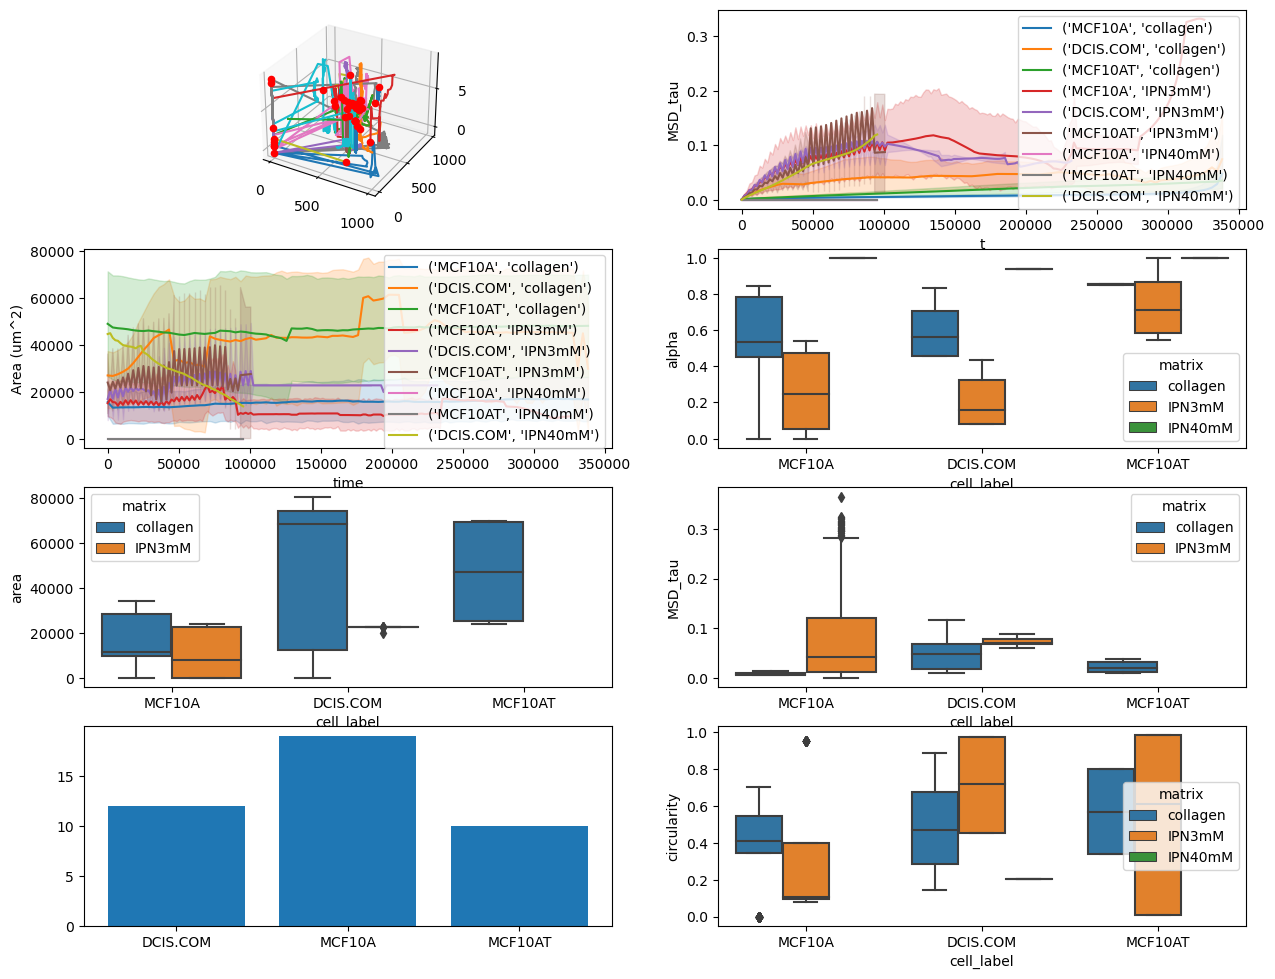

In [36]:

fig = plt.figure(figsize = (15,15))

ax = [ 
    fig.add_subplot(521, projection='3d'),
    fig.add_subplot(522),
    fig.add_subplot(523),
    fig.add_subplot(524),
    fig.add_subplot(525),
    fig.add_subplot(526),
    fig.add_subplot(527),
    fig.add_subplot(528)
]
for tags, data in df.groupby(["cell_label", "matrix", "ID"]):
    ax[0].plot3D(data["x"],  data["y"],data["z"])
    ax[0].scatter(data["x"].values[0],  data["y"].values[0],(data["z"]).values[0], label = False, color ="red")
    
    #ax[1].scatter(data["t"], data["MSD_tau"])
    x_data = np.arange(0,data["t"].values[-1], 10)
    y_data = power_law(x_data, data["ampltiude"].values[0], data["alpha"].values[0])
    #ax[1].plot(x_data, y_data, color = "red")


sns.lineplot(x = "t", y = "MSD_tau", hue =df[['cell_label', 'matrix']].apply(tuple, axis=1), data = df, ax = ax[1])

#ax[1].set_xlabel("time lag (s)")
#ax[1].set_ylabel("MSD")


sns.lineplot(x = "t", y = "area", hue = df[['cell_label', 'matrix']].apply(tuple, axis=1), data = df, ax = ax[2])
ax[2].set_xlabel("time")
ax[2].set_ylabel("Area (um^2)")

sns.boxplot(x = "cell_label", y= "alpha", data = df, hue = "matrix" ,ax = ax[3], showfliers = False)

mm = df.groupby(["cell_label", "matrix"]).mean().reset_index()
mm = df[(df["t"].values > 150000) & (df["t"].values < 250000)].reset_index()

sns.boxplot(x = "cell_label", y = "area", data = mm, hue = "matrix", ax = ax[4])
sns.boxplot(x = "cell_label", y = "MSD_tau", data = mm, hue = "matrix", ax = ax[5])


mm = df.groupby(["cell_label", "ID"]).mean().reset_index()
values, counts = np.unique(np.array(mm["cell_label"].values.astype(str)), return_counts=True)
ax[6].bar(values, counts)

sns.boxplot(x = "cell_label", y = "circularity", data = df, hue = "matrix", ax = ax[7])

In [102]:
df.to_csv("./dataStore/tracked_all_circ.csv")

In [81]:
df = pd.read_csv("./dataStore/tracked_all.csv")

array(['MCF10A', 'MCF10A', 'MCF10A', ..., 'MCF10AT', 'MCF10AT', 'MCF10AT'],
      dtype=object)